# Import necessary libraries

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow_datasets as tfds
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input, MobileNet
import zipfile, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping



# Load and Prepare Dataset

In [ ]:
def load_custom_dataset(data_dir, img_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    train_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical', # Change this line
        subset='training',
        shuffle=True
    )
    val_gen = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical', # Change this line
        subset='validation',
        shuffle=True
    )
    class_names = list(train_gen.class_indices.keys())
    return train_gen, val_gen, class_names

# Dispaly some samples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt # Make sure matplotlib.pyplot is imported

def display_samples(generator, class_names, n=9):
    images, labels = next(generator) # Changed generator.next() to next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        class_index = np.argmax(labels[i])
        plt.title(f"{class_names[class_index]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Found 1702 images belonging to 2 classes.
Found 425 images belonging to 2 classes.
Classes found: ['fracture', 'normal']
Displaying sample images from training set:


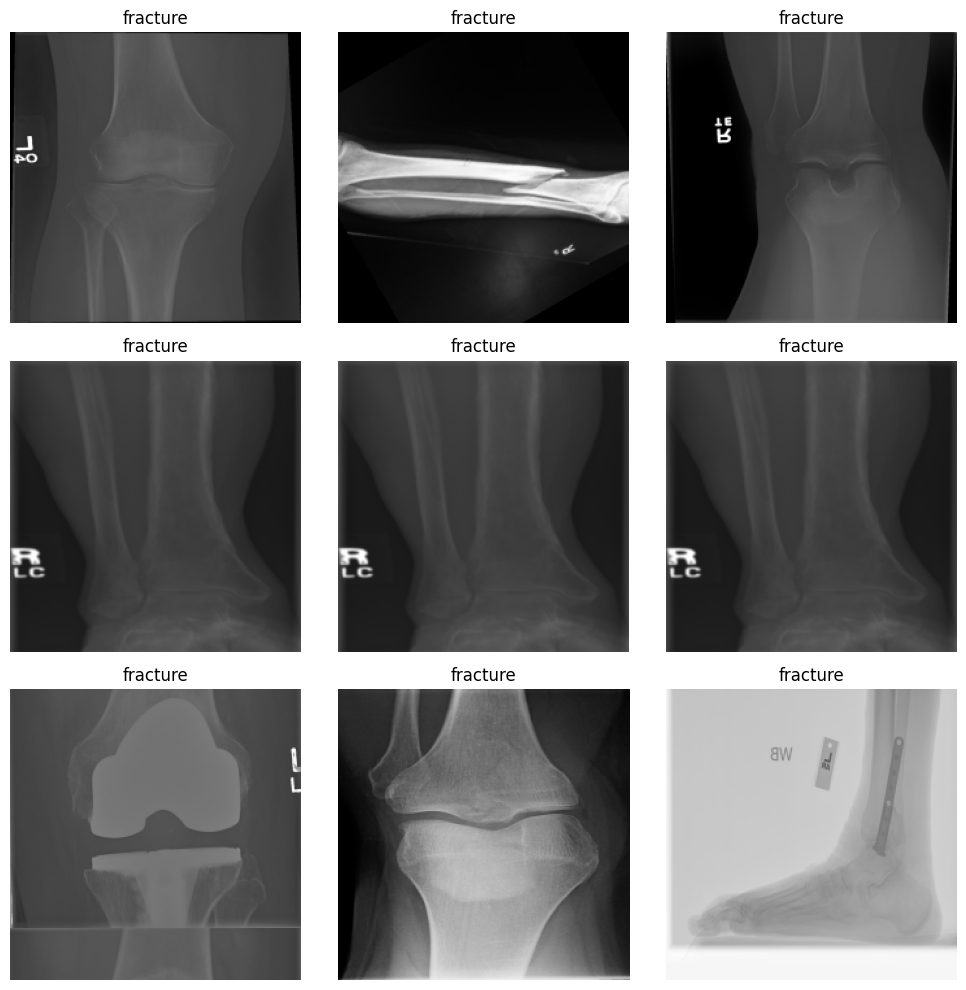

In [ ]:
data_path="/content/drive/My Drive/Bone fracture dataset/Dataset"
train_gen, val_gen, class_names = load_custom_dataset(data_path)

print("Classes found:", class_names)
print("Displaying sample images from training set:")
display_samples(train_gen, class_names)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a single ImageDataGenerator with a validation split
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
#  Training
train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

#  Validation (we'll later split it into validation + test)
val_test_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)


Found 1702 images belonging to 2 classes.
Found 425 images belonging to 2 classes.


# Build Transfer Learning Model MobileNet

In [ ]:
def build_transfer_model(input_shape, n_classes):
    base_model = MobileNet(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
import numpy as np

# Extract all validation data
val_images, val_labels = next(val_test_gen)
for _ in range(len(val_test_gen) - 1):
    x, y = next(val_test_gen)
    val_images = np.concatenate((val_images, x))
    val_labels = np.concatenate((val_labels, y))

# Split: 50% validation, 50% test
split_idx = len(val_images) // 2
valid_images, valid_labels = val_images[:split_idx], val_labels[:split_idx]
test_images, test_labels = val_images[split_idx:], val_labels[split_idx:]


# Compile and Train Model

In [ ]:
def compile_and_train_model(model, train_generator, val_generator, epochs):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', # Change this line
                  metrics=['accuracy'])
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=val_generator,
                        callbacks=[early_stopping])
    return history

model = build_transfer_model(input_shape=(224, 224, 3), n_classes=len(class_names))
history = compile_and_train_model(model, train_gen, val_gen, epochs=5)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 604ms/step - accuracy: 0.9102 - loss: 0.2814 - val_accuracy: 0.9412 - val_loss: 0.1610
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 343ms/step - accuracy: 0.9288 - loss: 0.2609 - val_accuracy: 0.9412 - val_loss: 0.1501
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.9389 - loss: 0.2028 - val_accuracy: 0.9365 - val_loss: 0.1387
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 333ms/step - accuracy: 0.9369 - loss: 0.2035 - val_accuracy: 0.9365 - val_loss: 0.1305
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.9273 - loss: 0.2246 - val_accuracy: 0.9412 - val_loss: 0.1268


## Evaluate on test set

Test accuracy: 95.77%
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step


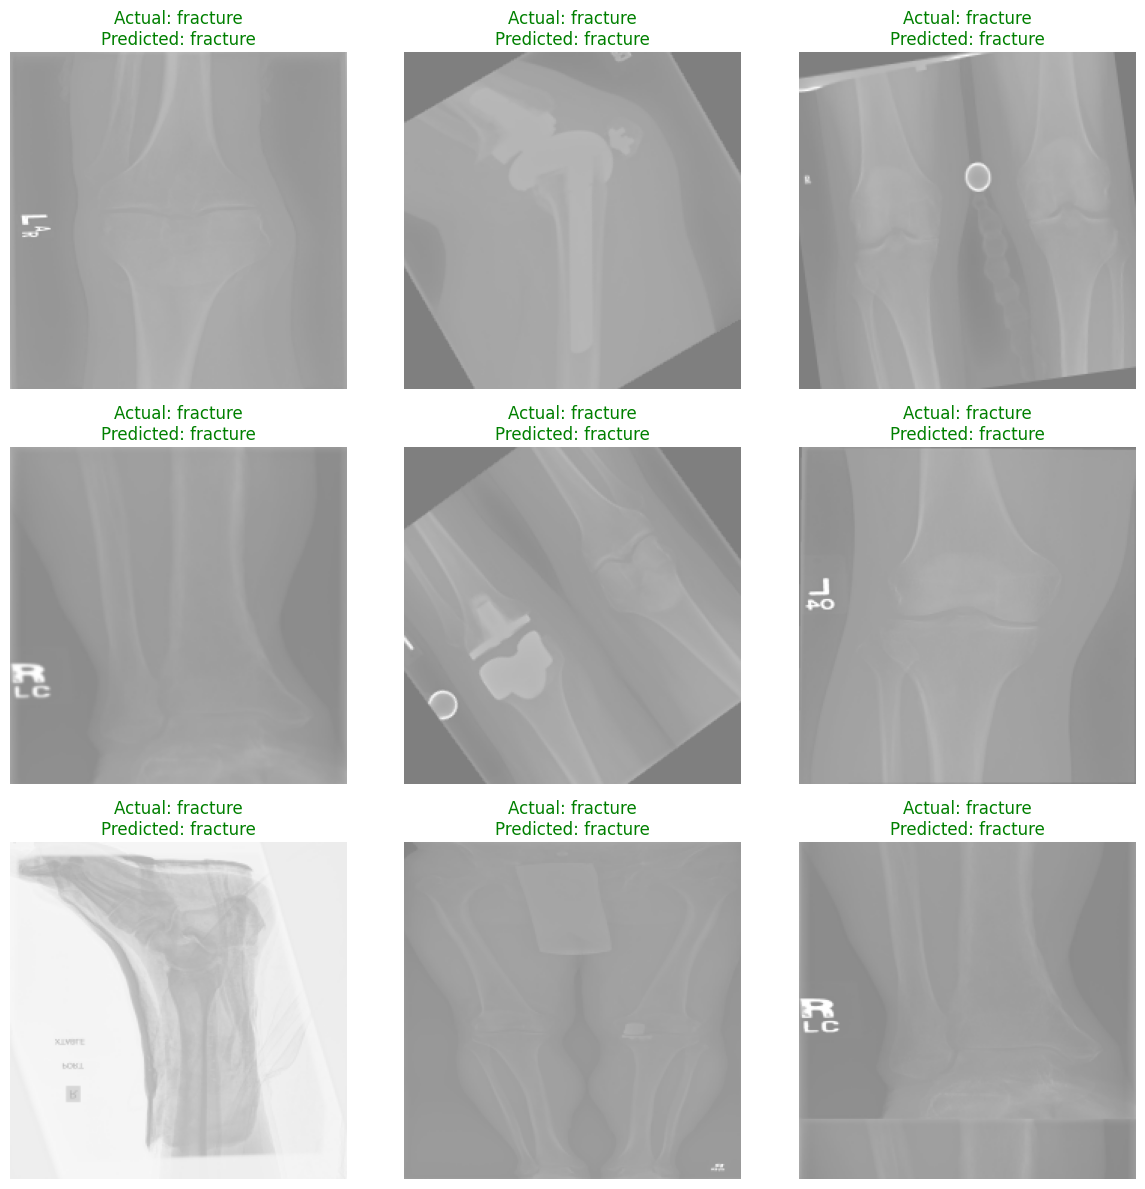

(0.10186801850795746, 0.9577465057373047)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_images, test_labels, class_names):
    loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
    print(f"Test accuracy: {accuracy:.2%}")

    predictions = model.predict(test_images)
    pred_classes = np.argmax(predictions, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(min(9, len(test_images))):
        plt.subplot(3, 3, i + 1)
        img = test_images[i]
        # Images typically come normalized [0,1] or [-1,1].
        # If they are in [-1,1] from preprocess_input, convert them back to [0,1] then [0,255]
        # If they are already [0,1] from ImageGenerator, then img = (img * 255).astype("uint8") is enough.
        # Assuming img is from MobileNet preprocess_input, which scales to [-1, 1]
        img = img * 0.5 + 0.5 # Convert from [-1, 1] to [0, 1]
        img = (img * 255).astype("uint8")


        plt.imshow(img)

        # Convert one-hot encoded test_labels[i] to a single class ID
        actual_class_id = np.argmax(test_labels[i])

        correct = (actual_class_id == pred_classes[i])
        color = "green" if correct else "red"

        plt.title(f"Actual: {class_names[actual_class_id]}\nPredicted: {class_names[pred_classes[i]]}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    return loss, accuracy

# Example usage (assuming model_phase1, test_images, test_labels, class_names are defined)
# evaluate_model(model_phase1, test_images, test_labels, class_names)

evaluate_model(model, test_images, test_labels, class_names)

## Strategy A: Unfreeze a specific number of layers from the end (experiment with differentnumbers of unfrozen layers).


[INFO] Unfreezing from layer 70...
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 470ms/step - accuracy: 0.9199 - loss: 0.5795 - val_accuracy: 0.8941 - val_loss: 0.2503
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 346ms/step - accuracy: 0.9859 - loss: 0.0380 - val_accuracy: 0.8494 - val_loss: 0.5784
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - accuracy: 0.9959 - loss: 0.0131 - val_accuracy: 0.1576 - val_loss: 7.6249
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - accuracy: 0.9985 - loss: 0.0122 - val_accuracy: 0.2729 - val_loss: 5.1140
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.9990 - loss: 0.0020 - val_accuracy: 0.9671 - val_loss: 0.0829
Test accuracy: 96.24%


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step


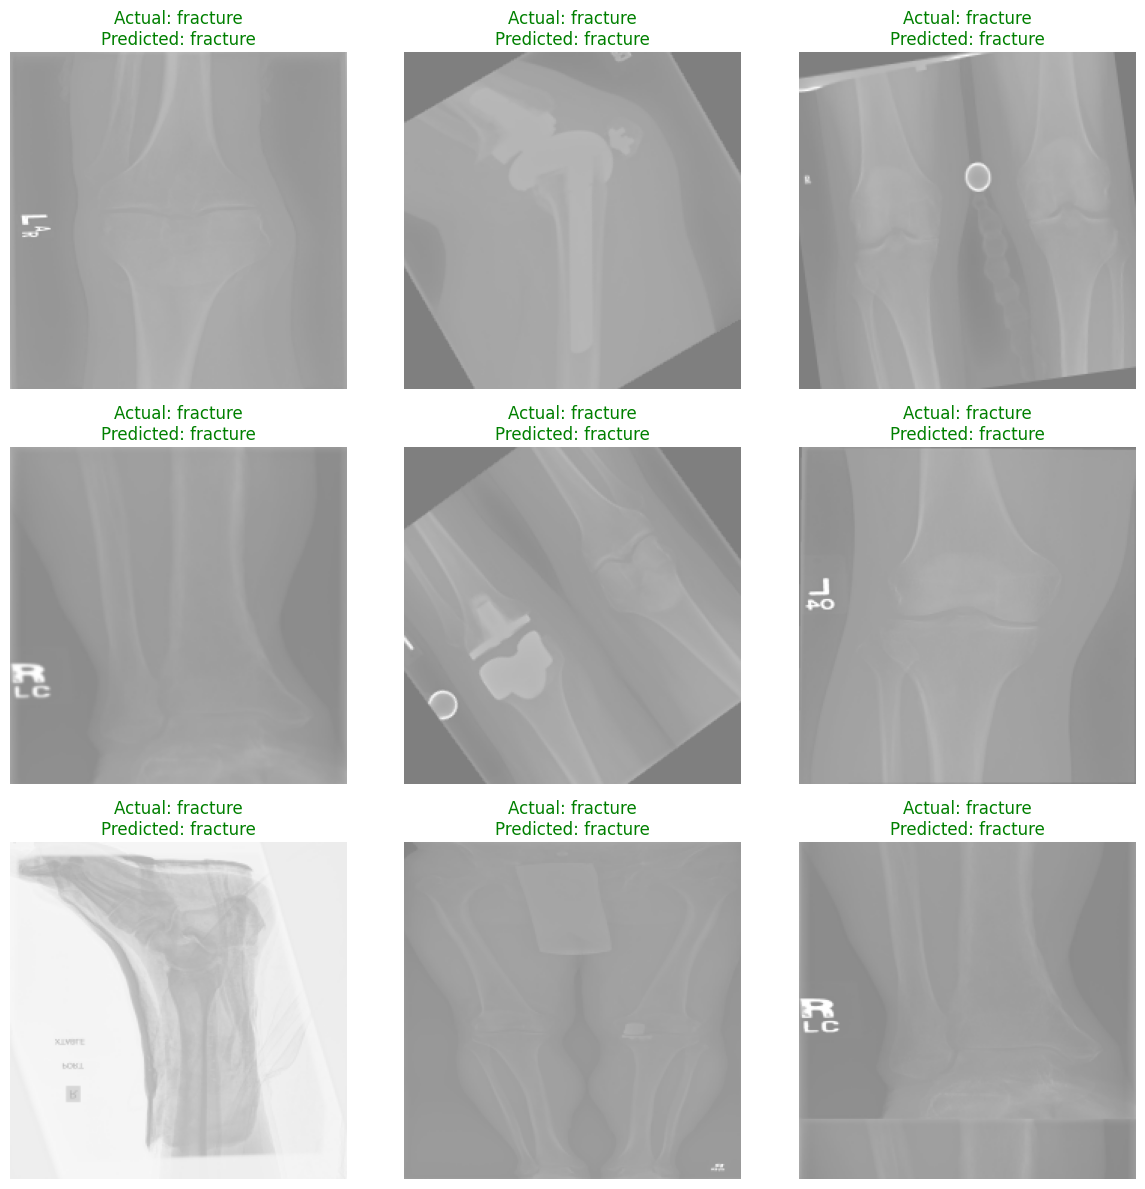

(0.0757521539926529, 0.9624413251876831)

In [ ]:
import tensorflow as tf # Ensure tensorflow is imported
import numpy as np # Ensure numpy is imported

def fine_tune_model(model,
                    train_generator, valid_generator, # Changed to accept generators
                    unfreeze_from_layer=70,
                    lr=0.01,
                    epochs=5):

    print(f"\n[INFO] Unfreezing from layer {unfreeze_from_layer}...")

    # Unfreeze layers from `unfreeze_from_layer` onward
    model.trainable = True
    # Assuming model.layers[1] is the MobileNet base model
    for i, layer in enumerate(model.layers[1].layers):
        if i >= unfreeze_from_layer:
            layer.trainable = True
        else:
            layer.trainable = False

    # Recompile with a lower learning rate
    # IMPORTANT: Change loss to 'categorical_crossentropy' for one-hot encoded labels
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy', # Changed loss function
                  metrics=['accuracy'])

    # Fine-tune the model using the generators
    history = model.fit(train_generator, # Use train_generator
                        validation_data=valid_generator, # Use valid_generator
                        epochs=epochs)
    return model, history

# You should then call this function using your generators:
# model_fine_tuned_layerwise, history_fine_tuned_layerwise = fine_tune_model(
#     model_phase1,
#     train_gen, val_gen, # Pass your train_gen and val_gen here
#     unfreeze_from_layer=70,
#     lr=0.01,
#     epochs=5
# )

# Compile the model
model2 = build_transfer_model(input_shape=(224, 224, 3), n_classes=len(class_names))
model2,history2 = fine_tune_model(model2, train_gen, val_gen, epochs=5)


# Now you can evaluate it
evaluate_model(model2, test_images, test_labels, class_names)


## Strategy B: Unfreeze complete blocks of layers (respecting

architectural boundaries).


[INFO] Fine-tuning last 2 blocks of the model...
Epoch 1/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 499ms/step - accuracy: 0.9379 - loss: 0.2656 - val_accuracy: 0.9859 - val_loss: 0.0454
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.9740 - loss: 0.0719 - val_accuracy: 0.9506 - val_loss: 0.0942
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 325ms/step - accuracy: 0.9606 - loss: 0.0846 - val_accuracy: 0.9882 - val_loss: 0.0296
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 319ms/step - accuracy: 0.9922 - loss: 0.0270 - val_accuracy: 0.9929 - val_loss: 0.0334
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.9808 - loss: 0.0515 - val_accuracy: 0.9882 - val_loss: 0.0234
Test accuracy: 99.53%
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 381ms/step


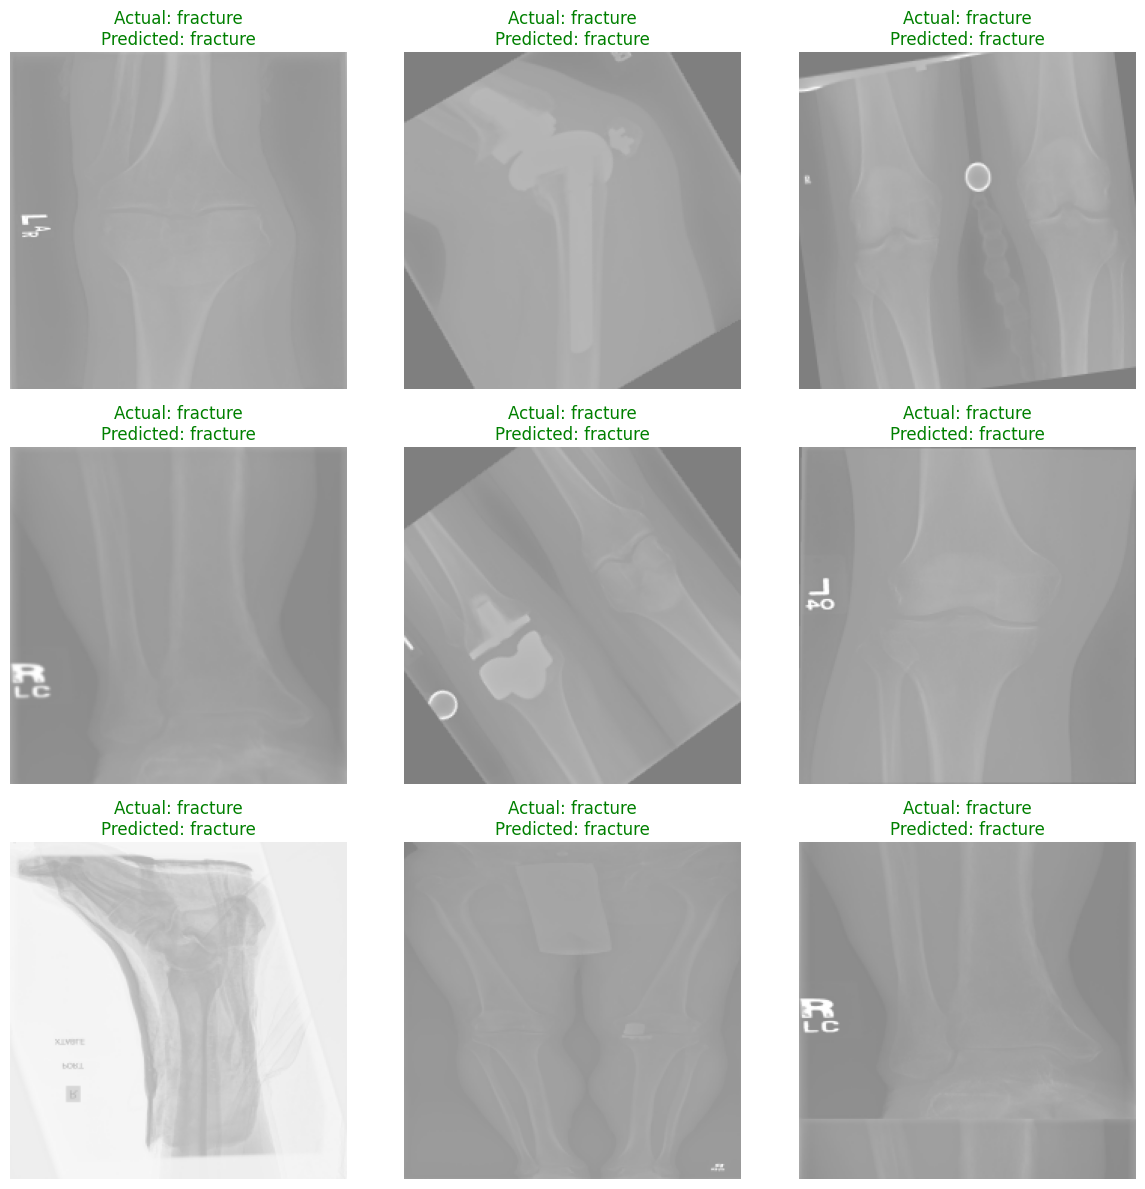

(0.010348673909902573, 0.9953051805496216)

In [ ]:
import tensorflow as tf
import numpy as np

def fine_tune_model_by_blocks(model,
                               train_generator,
                               val_generator,
                               blocks_to_unfreeze=2,
                               lr=0.01,
                               epochs=5):
    print(f"\n[INFO] Fine-tuning last {blocks_to_unfreeze} blocks of the model...")

    # Unfreeze selected blocks
    base_model = model.layers[1]
    sorted_blocks = sorted(set([
        int(layer.name.split('_')[0].replace('block', ''))
        for layer in base_model.layers if 'block' in layer.name
    ]), reverse=True)

    for block_num in sorted_blocks[:blocks_to_unfreeze]:
        for layer in base_model.layers:
            if f"block{block_num}_" in layer.name:
                layer.trainable = True

    # Compile the model
    model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
    )



    return model, history



model3 = build_transfer_model(input_shape=(224, 224, 3), n_classes=len(class_names))
# Compile the model
model3,history3 = fine_tune_model_by_blocks(model3, train_gen, val_gen, epochs=5)


# Now you can evaluate it
evaluate_model(model3, test_images, test_labels, class_names)

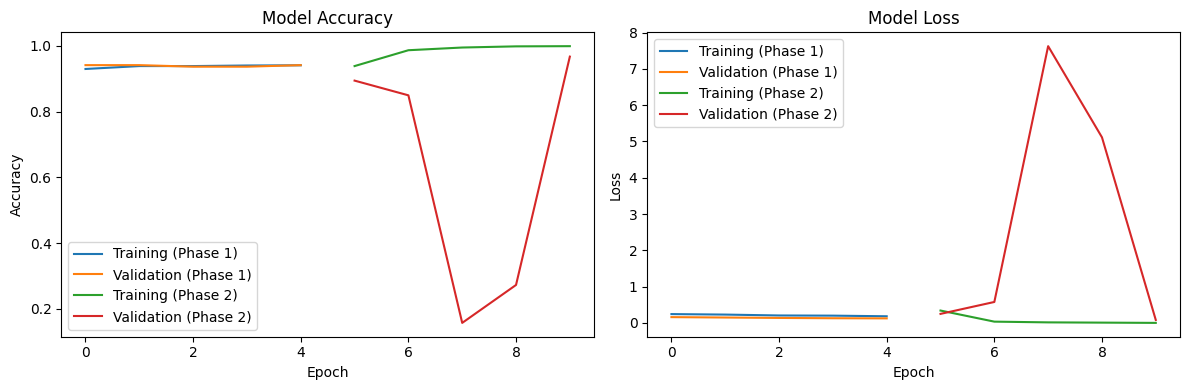

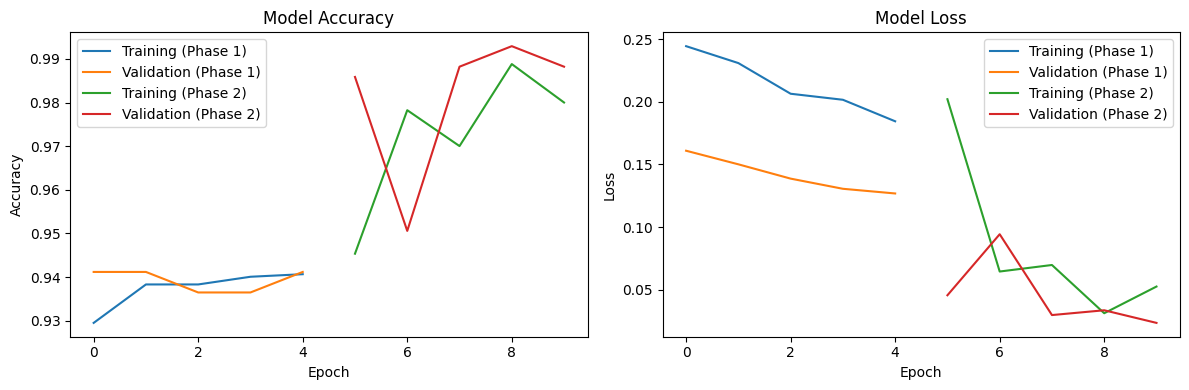

In [ ]:
def plot_learning_curves(history1, history2):
    """
    Plot learning curves from both training phases.

    Args:
        history1: History from initial training
        history2: History from fine-tuning
    """
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Training (Phase 1)')
    plt.plot(history1.history['val_accuracy'], label='Validation (Phase 1)')

    # Adjust for phase 2 (continue the graph)
    offset = len(history1.history['accuracy'])
    plt.plot(np.arange(offset, offset + len(history2.history['accuracy'])),
             history2.history['accuracy'], label='Training (Phase 2)')
    plt.plot(np.arange(offset, offset + len(history2.history['val_accuracy'])),
             history2.history['val_accuracy'], label='Validation (Phase 2)')

    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Training (Phase 1)')
    plt.plot(history1.history['val_loss'], label='Validation (Phase 1)')

    # Adjust for phase 2
    plt.plot(np.arange(offset, offset + len(history2.history['loss'])),
             history2.history['loss'], label='Training (Phase 2)')
    plt.plot(np.arange(offset, offset + len(history2.history['val_loss'])),
             history2.history['val_loss'], label='Validation (Phase 2)')

    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(history, history2)
plot_learning_curves(history, history3)